# Regression Metrics & Models



In [1]:
import sys, platform
import numpy as np, pandas as pd
import sklearn
import matplotlib.pyplot as plt
print('Python:', sys.version.split()[0])
print('Platform:', platform.platform())
print('NumPy:', np.__version__)
print('Pandas:', pd.__version__)
print('scikit-learn:', sklearn.__version__)

Python: 3.12.11
Platform: Linux-6.1.123+-x86_64-with-glibc2.35
NumPy: 2.0.2
Pandas: 2.2.2
scikit-learn: 1.6.1


## 1) Configuration

In [2]:
from dataclasses import dataclass

@dataclass
class Config:
    # Data source
    source: str = 'sklearn'    # 'csv' or 'sklearn'
    csv_path: str = ''         # path to your CSV when source='csv'
    target: str = ''           # target column when source='csv'
    sklearn_dataset: str = 'diabetes'  # 'diabetes' only (bundled)
    test_size: float = 0.2
    random_state: int = 42
    n_jobs: int = -1

cfg = Config()
cfg

Config(source='sklearn', csv_path='', target='', sklearn_dataset='diabetes', test_size=0.2, random_state=42, n_jobs=-1)

## 2) Load Data

In [9]:
from sklearn.datasets import load_diabetes

def load_data(cfg: Config):
    if cfg.source == 'csv':
        assert cfg.csv_path
        df = pd.read_csv(cfg.csv_path)
        assert cfg.target in df.columns
        X = df.drop(columns=[cfg.target])
        y = df[cfg.target]
        feature_names = X.columns.tolist()
        return X, y, feature_names
    else:
        ds = load_diabetes()
        X = pd.DataFrame(ds.data, columns=ds.feature_names)
        y = pd.Series(ds.target, name='target')
        return X, y, ds.feature_names

X, y, feature_names = load_data(cfg)
print('Shape:', X.shape)
display(pd.concat([X.head(), y.head()], axis=1).head())

Shape: (442, 10)


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


## 3) Train/Test Split

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=cfg.test_size, random_state=cfg.random_state
)
X_train.shape, X_test.shape

((353, 10), (89, 10))

## 4) Preprocessing (Impute + Scale)

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

preprocess = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])
preprocess

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

## 5) Models

In [12]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(alpha=1.0, random_state=cfg.random_state),
    'Lasso': Lasso(alpha=0.01, random_state=cfg.random_state, max_iter=10000),
    'RandomForest': RandomForestRegressor(n_estimators=300, random_state=cfg.random_state, n_jobs=cfg.n_jobs),
}
list(models.keys())

['Linear', 'Ridge', 'Lasso', 'RandomForest']

## 6) Evaluation Utilities

In [15]:
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def make_pipe(est):
    return Pipeline([('prep', preprocess), ('model', est)])

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def evaluate(name, est, X_train, y_train, X_test, y_test):
    pipe = make_pipe(est)
    cv = KFold(n_splits=5, shuffle=True, random_state=cfg.random_state)
    scoring = {'r2': 'r2', 'neg_mse': 'neg_mean_squared_error'}
    cv_res = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=cfg.n_jobs)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    metrics = {
        'model': name,
        'cv_r2_mean': float(np.mean(cv_res['test_r2'])),
        'cv_rmse_mean': float(np.mean(np.sqrt(-cv_res['test_neg_mse']))),
        'test_mae': float(mean_absolute_error(y_test, y_pred)),
        'test_mse': float(mean_squared_error(y_test, y_pred)),
        'test_rmse': float(rmse(y_test, y_pred)),
        'test_r2': float(r2_score(y_test, y_pred)),
    }
    return metrics, pipe, y_pred

## 7) Run Comparisons

In [16]:
results = []
artifacts = {}
for name, est in models.items():
    m, pipe, y_pred = evaluate(name, est, X_train, y_train, X_test, y_test)
    results.append(m)
    artifacts[name] = {'pipe': pipe, 'y_pred': y_pred}

results_df = pd.DataFrame(results).sort_values(by='test_rmse')
display(results_df)
results_df.to_csv('regression_results.csv', index=False)
best_name = results_df.iloc[0]['model']
best_pipe = artifacts[best_name]['pipe']
print('Best model:', best_name)

,model,cv_r2_mean,cv_rmse_mean,test_mae,test_mse,test_rmse,test_r2
1,Ridge,0.480784,55.374175,42.811999,2892.014566,53.777454,0.454147
2,Lasso,0.480506,55.387754,42.795018,2898.368019,53.836493,0.452947
0,Linear,0.480365,55.394633,42.794095,2900.193628,53.853446,0.452603
3,RandomForest,0.414224,58.678233,44.752022,3016.354075,54.921344,0.430678


Best model: Ridge


## 8) Plots of the Best Model

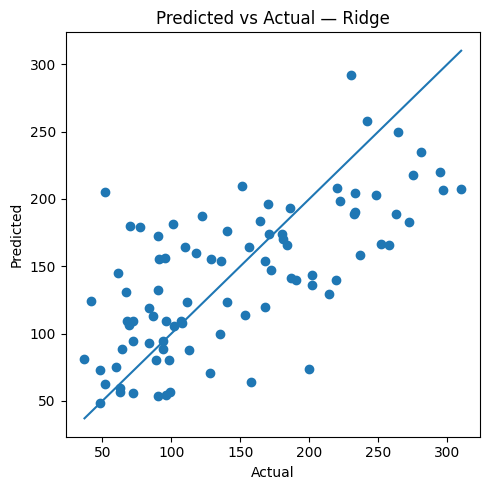

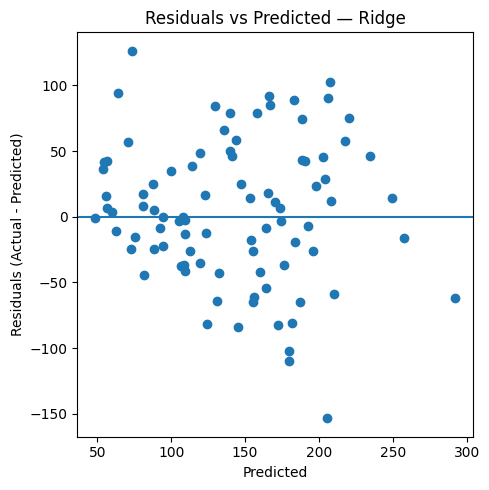

In [17]:
y_pred = artifacts[best_name]['y_pred']

# Predicted vs Actual
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred)
min_v = min(y_test.min(), y_pred.min())
max_v = max(y_test.max(), y_pred.max())
plt.plot([min_v, max_v], [min_v, max_v])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Predicted vs Actual — {best_name}')
plt.tight_layout()
plt.show()

# Residuals vs Predicted
residuals = y_test - y_pred
plt.figure(figsize=(5,5))
plt.scatter(y_pred, residuals)
plt.axhline(0)
plt.xlabel('Predicted')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title(f'Residuals vs Predicted — {best_name}')
plt.tight_layout()
plt.show()

## 9) Feature Importance / Coefficients (Quick View)

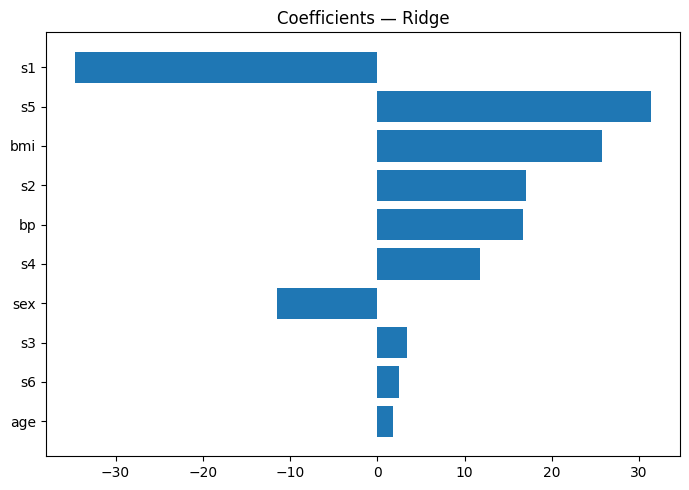

In [19]:
pipe = best_pipe
model = pipe.named_steps['model']

def plot_bar(names, values, title):
    idx = np.argsort(np.abs(values))[::-1]
    values = values[idx]
    names = [names[i] for i in idx]
    top_k = min(15, len(values))
    plt.figure(figsize=(7,5))
    plt.barh(range(top_k), values[:top_k][::-1])
    plt.yticks(range(top_k), names[:top_k][::-1])
    plt.title(title)
    plt.tight_layout()
    plt.show()

try:

    if hasattr(model, 'coef_'):

        pipe.fit(X_train, y_train)
        coefs = model.coef_.ravel() if hasattr(model.coef_, 'ravel') else model.coef_
        plot_bar(feature_names, np.array(coefs), f'Coefficients — {best_name}')
    elif hasattr(model, 'feature_importances_'):
        pipe.fit(X_train, y_train)
        imps = model.feature_importances_
        plot_bar(feature_names, np.array(imps), f'Feature Importances — {best_name}')
    else:
        print('No quick importance available for this model.')
except Exception as e:
    print('Could not compute importance:', e)